In [1]:
# The number of entries to read in. Use it to have fast turn-around
max_events = None
# Number on CV folds
n_cv = 5

import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.base import clone
import lightgbm as lgb

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)

import gc
import copy

import mlflow
import mlflow.sklearn
from mlflow.entities import ViewType, SourceType

import keggler as kg

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

PATH = '/home/mlisovyi/.kaggle/competitions/santander-customer-transaction-prediction/'

print(os.listdir(PATH))

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
%load_ext autoreload
%autoreload 2

# Raw data

In [3]:
y_trn = pd.read_csv(PATH+'train.csv', usecols=['target'])

# Experiment results

In [4]:
from  mlflow.tracking import MlflowClient
client = MlflowClient()

In [5]:
oofs = {}
subs = {}
aucs = {} 

for exp in [x for x in client.list_experiments() if x.name in ['HP_RS_Stratified', 'HP_RS_Stratified_RandomForest']]:
    exp_id = exp.experiment_id
    for run_info in client.list_run_infos(exp_id, ViewType.ACTIVE_ONLY):
        run_id = run_info.run_uuid
        exp_run_id = '{}_{}'.format(exp_id, run_id)
        
        # pick up runs with artifacts
        if os.listdir(run_info.artifact_uri):         
            # retrieve metric values for each run
            run = client.get_run(run_id)
            aucs[exp_run_id] = [m.value for m in run.data.metrics if m.key=='AUC'][0]

            # retrieve OOF and submission predictions
            oofs[exp_run_id] = pd.read_csv('{}/oof.csv'.format(run_info.artifact_uri), header=None)[0].astype(np.float32)
            subs[exp_run_id] = pd.read_csv('{}/sub.csv'.format(run_info.artifact_uri))['target'].astype(np.float32)

In [20]:
df_oof = pd.DataFrame(oofs)#({k:v[0] for k,v in oofs.items()})
df_sub = pd.DataFrame(subs)
df_auc = pd.Series(aucs)

In [21]:
df_auc.nlargest()

2_0d5df73df1764ba78aa667cc3af11468    0.899863
2_6f5dc07b58e94cb1be7ade3fc2a3f09a    0.899863
2_e111aaf834be4f718211858bda40117c    0.899863
2_51d71882a84a4c97b7a6f2c6b4bd5838    0.899862
2_a1864afbf5fe40ce997f87cfb9893e80    0.899607
dtype: float64

In [30]:
del oofs, subs

In [31]:
df_oof.memory_usage(deep=True).sum()/1024**2

126.64802551269531

# EDA

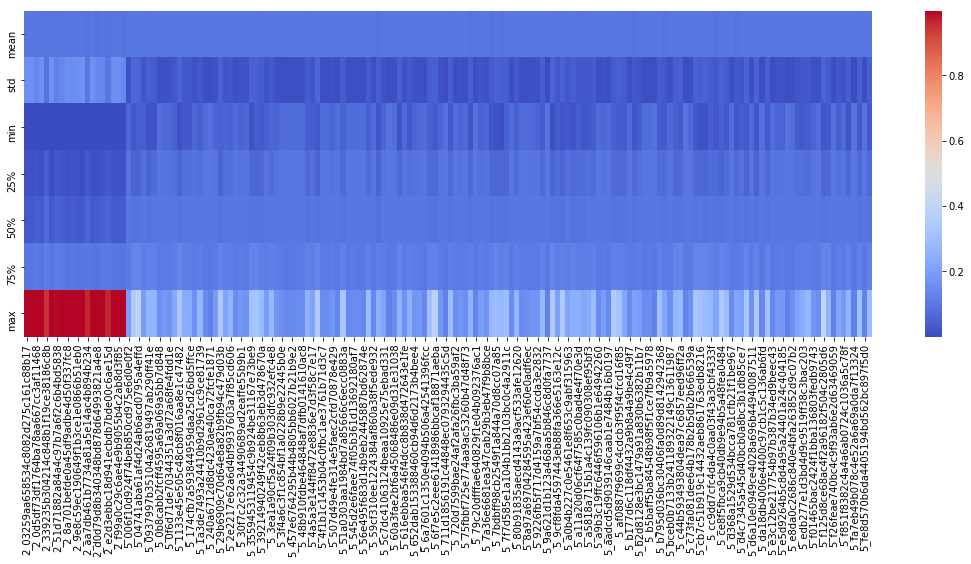

In [22]:
plt.figure(figsize=(19,6))
sns.heatmap(df_oof.describe().drop('count'), cmap='coolwarm')

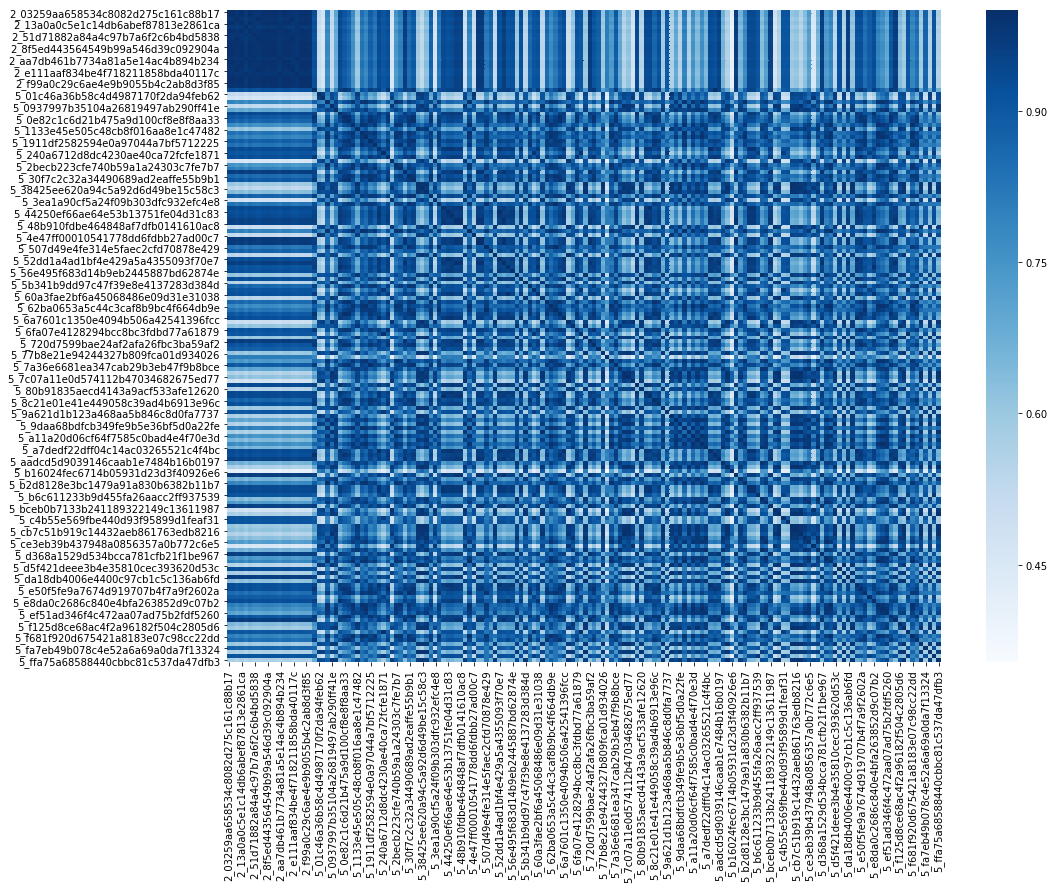

In [23]:
plt.figure(figsize=(16,12))
sns.heatmap(df_oof.rank(pct=True).iloc[:50000].corr(), cmap='Blues')

# Stacking

In [32]:
n_trn = None

In [33]:
from sklearn.model_selection import ParameterSampler, ParameterGrid
par_grid = ParameterGrid([{'C': [1e-1, 1e-2, 1e-3, 1e-4],
                           'penalty': ['l1', 'l2']},
                         ])

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test = {
    'num_leaves': [10,20,50,80,100,150,200],
    'min_child_samples': [100,300,500,700,900],
    'subsample': [0.1, 0.2, 0.4, 0.6, 0.8],
    'colsample_bytree': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]
}
par_sampler = ParameterSampler(param_test, n_iter=1, random_state=314)

In [34]:
mlflow.set_experiment('TMP')

for ps in par_sampler:
    print(ps)
    with mlflow.start_run(source_type=SourceType.NOTEBOOK, source_version=kg.get_last_git_commit()):
        mlflow.set_tag('model_name', 'lgbm')
        for k, v in ps.items():
            mlflow.log_param(k, v)
        mlflow.log_param('N', n_trn)
        
        
        #_mdl = clone(mdl)        
        _mdl = kg.StackingClassifier(lgb.LGBMClassifier(
                                    max_depth=-1,
                                    random_state=314,
                                    silent=True,
                                    metric='None',
                                    learning_rate=0.1,
                                    n_jobs=4,
                                    n_estimators=5000,
                                    importance_type='gain'
                            ),
                            df_oof.iloc[:n_trn],
                            df_sub,
                            n_cv=5, random_state=31416,
                            metric=roc_auc_score,
                            n_jobs=3,
                            verbose=False,
                            use_ranks=True
                           )
        _mdl.meta_model.set_params(**ps)            
        _ = _mdl.fit(df_oof.iloc[:n_trn,:2], y_trn.iloc[:n_trn])
        
        mlflow.log_metric("AUC", _mdl.eval_results_['meta_score_mean'])
        mlflow.log_metric("AUC_STD", _mdl.eval_results_['meta_score_std'])
        for i,m in enumerate(_mdl.eval_results_['meta_score_folds']):
            mlflow.log_metric("AUC_Fold{}".format(i), m)
        mlflow.log_metric("Time_sec", _mdl.eval_results_['fit_time'])

{'subsample': 0.1, 'min_child_samples': 900, 'colsample_bytree': 0.2, 'num_leaves': 200}
Shape of datafit in fiting: (200000, 166)
Total execution time of the kfold learning: 49.6 sec
Scores in individual folds: (0.9020280569581983, 0.897671577218546, 0.9003884240553762, 0.9026260615052376, 0.8947677208910815)
Stacked score: 0.89950 ± 0.00292
